# Lab session: BAYESIAN INFERENCE

## The Coin Problem ([flipsimu.com](https://flipsimu.com/))


We often encounter situations where we want to estimate the probability of an event based on observed data. The classic *coin toss* is a simple yet powerful example. Suppose we have a coin, but we don't know whether it's fair or biased.  When flipping a coin, we may wonder whether it is fair, meaning it has an equal chance of landing on heads or tails, or biased, favoring one outcome more than the other. Since we cannot know this probability just by looking at the coin, we must infer it from experimental evidence. That is, from the results of multiple coin tosses. This small experiment captures the essence of probabilistic modeling: using observed data to update our beliefs about an unknown parameter, in this case, the probability $p$ of getting heads through logical and mathematical reasoning. Let's denote:


- Random variable $X$ ~ $Bernoulli(p)$, where:

- $X = 1$ if the coin shows *heads*, and 0 if *tails*.

- $p$ is the probability of getting heads.


**Our goal: infer the value of $p$ from observed flips of the coin.**


The probability mass function (pmf) of the Bernoulli distribution is:


$$ P(X = x | p) = p^x (1 - p)^{1 - x} $$


where x ∈ {0, 1}.

In [1]:
# Import necessary libraries
import numpy as np
import math
from scipy.stats import beta, bernoulli
import matplotlib.pyplot as plt

## 1-  Updating our Beliefs

Before flipping, we don't know $p$.  We express our prior belief about the coin's bias using a Beta distribution:


$$ p \sim \text{Beta}(\alpha, \beta) $$

where $\alpha$ and $\beta$ represent our prior counts of heads and tails, respectively.   Examples:

-  $\text{Beta}(1, 1) $: uniform prior (no information)

- $\text{Beta}(2, 1) $:prior belief favoring heads

- $\text{Beta}(1, 2) $:prior belief favoring tails


The Beta is special because it is the conjugate prior to the Bernoulli (or Binomial). That means, after observing data, the posterior is also a Beta, which makes math easy.


The Beta distribution has a probability density function:


$$ f(p; \alpha, \beta) = \frac{p^{\alpha - 1}(1 - p)^{\beta - 1}}{B(\alpha, \beta)} $$


where $B(\alpha, \beta)$ is the Beta function.

 After observing data (n flips with s heads), the posterior distribution is updated using Bayes' theorem:


$$Posterior: p | \text{data} \sim \text{Beta}(\alpha + s, \beta + n - s) $$

In [5]:
def update_beta_posterior(alpha_prior, beta_prior, data):
  data = np.asarray(data)
  s = int(np.sum(data)) # number of heads
  n = data.size # total flips
  return alpha_prior + s, beta_prior + (n - s)

In [9]:
data = np.array([1, 0, 1, 1, 0, 1, 1, 1, 0, 1]) # 10 flips, 7 heads
update_beta_posterior(5, 5, data)

(12, 8)



### Posterior mean

After observing data, the posterior is:

$
p | \text{data} \sim \text{Beta}(\alpha_\text{post}, \beta_\text{post})
$

* The **posterior mean** is the expected value of $p$ under this Beta distribution (good for predictions):

$$
E[p|\text{data}] = \frac{\alpha_\text{post}}{\alpha_\text{post} + \beta_\text{post}}
$$

It is your **average belief** for $p$ after combining prior and data.


**Example using the previous numbers in the code**:

* Posterior: $(\alpha_\text{post} = 12), (\beta_\text{post} = 8)$

$$
E[p|\text{data}] = \frac{12}{12+8} = \frac{12}{20} = 0.6
$$

 So after 10 flips with prior 5/5, we expect the coin to come up heads **60% of the time**.

---

###  MAP (Maximum a Posteriori)

The **MAP estimate** is the value of $p$ that maximizes the posterior distribution (good for point estimate in decision-making or reporting the most probable value). For Beta:

$$
p_\text{MAP} = \frac{\alpha_\text{post} - 1}{\alpha_\text{post} + \beta_\text{post} - 2}, \quad \text{valid if } \alpha_\text{post}, \beta_\text{post} > 1
$$

it is the most likely value of $p$ given prior + data.


Using The numbers:

$$
p_\text{MAP} = \frac{12-1}{12+8-2} = \frac{11}{18} \approx 0.611
$$

* Slightly higher than the mean (0.6) because the Beta posterior is skewed a bit.


In [11]:
def posterior_mean(alpha_post, beta_post):
  return alpha_post / (alpha_post + beta_post)


def posterior_map(alpha_post, beta_post):
  return (alpha_post - 1) / (alpha_post + beta_post - 2)

## 2-  Visualizing Beliefs:

We visualize how the Beta distribution looks for different parameter values.
This helps us understand how prior beliefs about fairness shape our expectations.

<Axes: xlabel='p (probability of Heads)', ylabel='Density'>

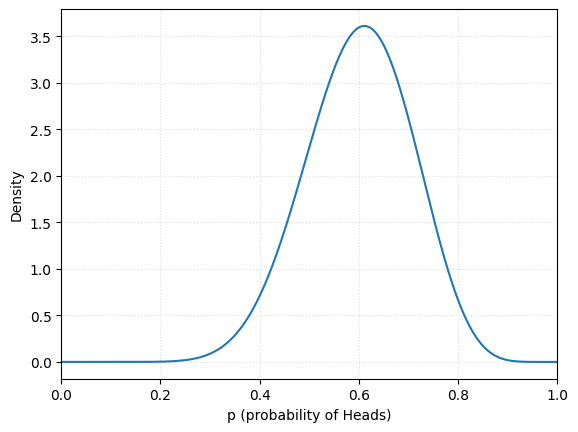

In [14]:
def plot_beta(alpha_post, beta_post, ax=None, label=None):
  if ax is None:
    fig, ax = plt.subplots()
  xs = np.linspace(0, 1, 500)
  ys = beta.pdf(xs, alpha_post, beta_post)
  ax.plot(xs, ys, label=label or f"Beta({alpha_post:.2f},{beta_post:.2f})")
  ax.set_xlabel('p (probability of Heads)')
  ax.set_ylabel('Density')
  ax.set_xlim(0, 1)
  ax.grid(True, linestyle=':', alpha=0.4)
  if label is not None:
    ax.legend()
  return ax

plot_beta(12, 8, ax=None, label=None)

- The peak of the curve is most likely the value of (MAP).

- The center of mass of the curve or mean is the expected value of  (posterior mean).

- The width of the curve represents how uncertain we are:

        - Narrow → confident about the coin's bias

        - Wide → uncertain about the coin's bias.


On our curve, the spread shows that with 10 flips + prior 5/5, we're fairly confident, but not absolutely certain, that the probability of heads is between ~0.4 and ~0.8.

## 3-  Choosing Priors:

We consider different prior beliefs:
- Beta(1,1): uninformative (uniform)
- Beta(2,1): favors heads
- Beta(1,2): favors tails
- Beta(0.5,0.5): Jeffreys prior, gives more weight to extreme probabilities, useful for invariance in Bayesian statistics.



In [16]:
priors = {
'uninformative (Beta(1,1))': (1.0, 1.0),
'weak heads prior (Beta(2,1))': (2.0, 1.0),
'weak tails prior (Beta(1,2))': (1.0, 2.0),
'Jeffreys prior (Beta(0.5,0.5))': (0.5, 0.5),
}

## 4- Plotting Prior, Likelihood, and Posterior:

The likelihood of observing s heads in n flips is:


$$ L(p|data) = p^s (1-p)^{n-s} $$


We plot prior, likelihood, and posterior to see how the data shifts our belief.

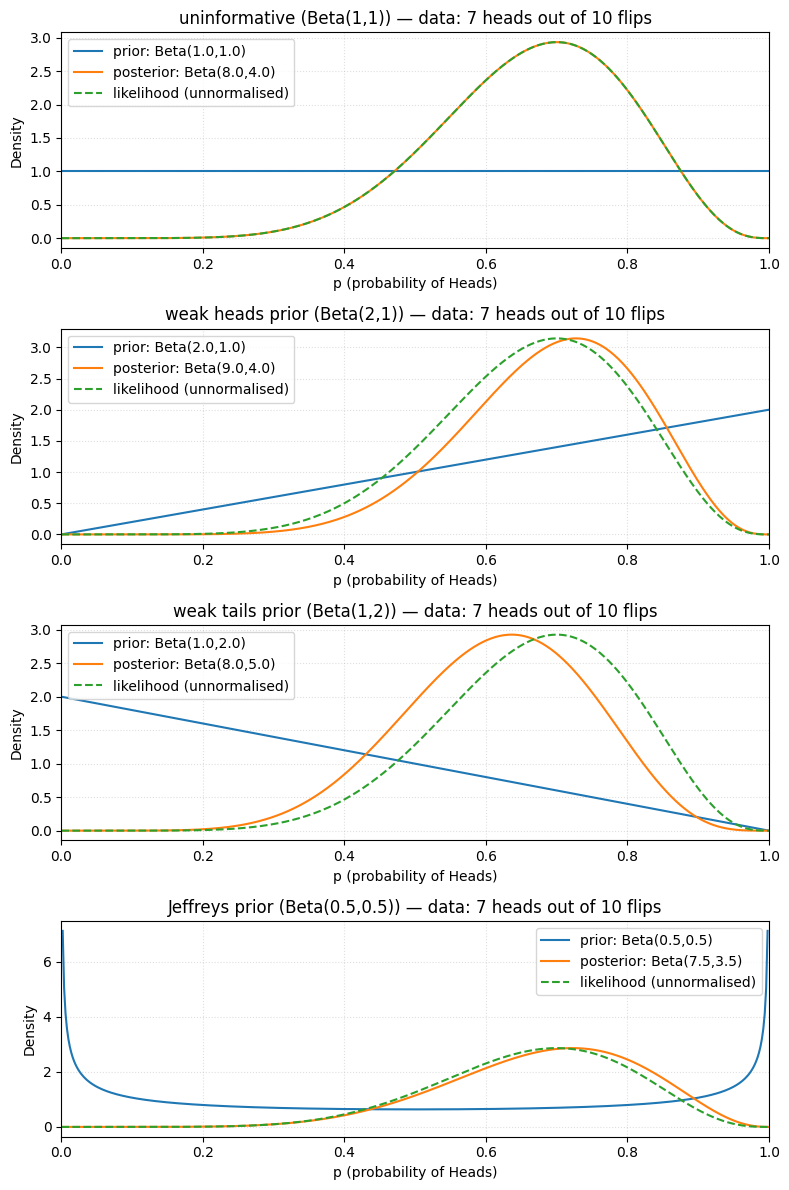

In [17]:
fig, axes = plt.subplots(len(priors), 1, figsize=(8, 3*len(priors)))
if len(priors) == 1:
  axes = [axes]


for ax, (name, (a0, b0)) in zip(axes, priors.items()):
  a_post, b_post = update_beta_posterior(a0, b0, data)
  plot_beta(a0, b0, ax=ax, label=f'prior: Beta({a0},{b0})')
  plot_beta(a_post, b_post, ax=ax, label=f'posterior: Beta({a_post},{b_post})')


  xs = np.linspace(0, 1, 500)
  s = np.sum(data)
  n = data.size
  likelihood = (xs ** s) * ((1 - xs) ** (n - s))
  likelihood = likelihood / np.max(likelihood) * np.max(beta.pdf(xs, a_post, b_post))
  ax.plot(xs, likelihood, linestyle='--', label='likelihood (unnormalised)')
  ax.set_title(name + f' — data: {int(s)} heads out of {int(n)} flips')
  ax.legend()


plt.tight_layout()

## 5-  Posterior Summary:

We summarize our posterior distribution using:
- Posterior mean: expected p
- MAP: most probable p
- Credible interval: 95% interval containing plausible p values.





In [19]:
chosen_prior = priors['uninformative (Beta(1,1))']
alpha1, beta1 = chosen_prior
alpha_post, beta_post = update_beta_posterior(alpha1, beta1, data)


print('Data: {} heads out of {} flips'.format(int(np.sum(data)), data.size))
print('Prior: Beta({},{})'.format(alpha1, beta1))
print('Posterior: Beta({:.2f},{:.2f})'.format(alpha_post, beta_post))
print('Posterior mean: {:.3f}'.format(posterior_mean(alpha_post, beta_post)))
print('Posterior MAP: {:.3f}'.format(posterior_map(alpha_post, beta_post)))
print('95% credible interval (equal-tailed): [{:.3f}, {:.3f}]'.format(*beta.interval(0.95, alpha_post, beta_post)))

Data: 7 heads out of 10 flips
Prior: Beta(1.0,1.0)
Posterior: Beta(8.00,4.00)
Posterior mean: 0.667
Posterior MAP: 0.700
95% credible interval (equal-tailed): [0.390, 0.891]


## 6- Sequential Updating:

We visualize how the posterior evolves as new data points (coin flips) arrive.
This demonstrates the cumulative nature of Bayesian updating.




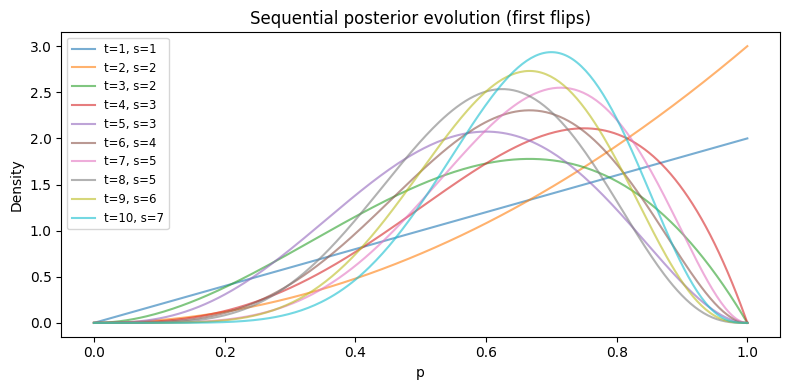

In [21]:

seq_data = np.array([1,1,0,1,0,1,1,0,1,1])
alpha, beta_ = 1.0, 1.0
fig, ax = plt.subplots(figsize=(8,4))
for t, obs in enumerate(seq_data, start=1):
  alpha += int(obs)
  beta_ += (1 - int(obs))
  xs = np.linspace(0,1,300)
  ys = beta.pdf(xs, alpha, beta_)
  ax.plot(xs, ys, alpha=0.6, label=f't={t}, s={int(np.sum(seq_data[:t]))}')
ax.set_title('Sequential posterior evolution (first flips)')
ax.set_xlabel('p')
ax.set_ylabel('Density')
ax.legend(fontsize='small')
plt.tight_layout()

## 7-  Hypothesis Check:

We've been updating our belief about the coin's bias ($p$) using a Beta posterior. Now, we want to **answer a specific question**:

> “What is the probability that the coin is biased towards heads?”

* Mathematically:
  $$
  P(p > 0.5 \mid \text{data}) = 1 - F(0.5; \alpha_{post}, \beta_{post})
  $$
  where F is the Beta cumulative distribution function.

* This is the posterior probability that ($p$) (probability of heads) is **greater than 0.5**.




###  Interpretation

* If it is **close to 1** → strong evidence coin favors heads
* If it is is **around 0.5** → coin is probably fair, data is ambiguous
* If it is is **close to 0** → strong evidence coin favors tails



In [25]:

prob_p_gt_half = 1 - beta.cdf(0.5, alpha_post, beta_post)
print('\nPosterior probability p > 0.5: {:.3f}'.format(prob_p_gt_half))


Posterior probability p > 0.5: 0.887


There's a **88% chance the coin is biased toward heads**, given the data and prior.

## LET PRACTISE 😁😁


1) Change the dataset to 100 flips with 53 heads. Compare posterior mean and credible interval for different priors.

2) For a coin that comes up heads 0 times in 10 flips, why is the posterior mean not exactly 0? What role does the prior play?


3) Simulate data from a biased coin ($p=0.7$). Repeat the experiment many times and compute how often $P(p>0.5)>0.95$.


In [27]:
# 1) Compare posterior mean

## TO DO: DEFINE YOUR DATA

# TO DO; DEFINE YOU DIFFERENT PRIORS

# Function to compute posterior mean and 95% credible interval
def posterior_summary(alpha_prior, beta_prior, data):

    # TO DO: DEFINE YOUR UPDATE POSTERIOR PARAMETERS

    # TO DO: DEFINE THE MEAN

    ci_lower, ci_upper = beta.ppf([0.025,0.975], alpha_post, beta_post)
    return mean, (ci_lower, ci_upper)

# Compare priors
for name, (a0,b0) in priors.items():
    mean, ci = posterior_summary(a0, b0, data)
    print(f"{name}: posterior mean={mean:.3f}, 95% CI=({ci[0]:.3f}, {ci[1]:.3f})")


In [ ]:
# 2) Coin comes up heads 0 times in 10 flips – posterior mean not 0


# TO DO: DEFINE DATA,10 flips, 0 heads

alpha_prior, beta_prior = 1,1  # uninformative prior

# TO DO: DEFINE ALPHA POSTERIOR AND BETA POSTERIOR

# TO DO: DEFINE POSTERIO MEAN

# PRINT AND ANSWER THE QUESTION
print("Posterior mean:", posterior_mean)

In [ ]:
# 3) Simulate biased coin


np.random.seed(42)
n_sim = 1000
n_flips = 10
p_true = 0.7
alpha_prior, beta_prior = 1,1

count = 0
for _ in range(n_sim):

    # TO DO: DEFINE YOUR DATA USING BINOMIAL DISTRIBUTION

   # TO DO: DEFINE ALPHA POSTERIOR AND BETA POSTERIOR

    # TO DO: DEFINE POSTERIOR PROBABILITY AS IN PART 7

    # if prob > 0.95:
    #     count += 1

print(f"Fraction of simulations where P(p>0.5)>0.95: {count/n_sim:.3f}")





This shows the power of the Bayesian test: how often we are highly confident (posterior probability > 0.95) that the coin favors heads when it really does (p=0.7).

- With small n_flips=10, it won’t always exceed 0.95 → small sample uncertainty.

- With more flips, the fraction would approach 1.